In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
from matplotlib.pyplot import figure
torch.manual_seed(1)

train_data = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_data = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader
print("Train_data size:", len(train_data),"\nTest_data size:", len(test_data))

Train_data size: 60000 
Test_data size: 10000


In [3]:
class DeepClassifier(nn.Module):
    def __init__(self,):
        super(DeepClassifier, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#train function
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt = pd.DataFrame()
    trainAvgLossArr = []
    trainAvgAccArr = []
    firstParaWgt = {}

    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0
        epoch_df = pd.DataFrame()

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
        #Weight Collection
        for name, parameter in model.named_parameters():
            #print(name)
            if'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
                epoch_df = pd.concat([epoch_df, pd.DataFrame(weights).T], axis = 1) 

        modelParamWgt = pd.concat([modelParamWgt, epoch_df], axis = 0)     

       
        epochLoss = lossSum/n_total_steps
        epochAcc = totalacc/n_total_steps
        #print("Train Avg loss:",trainAvgLoss)
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [4]:

a=[]
tempModel = DeepClassifier()
for i in tempModel.parameters():
    a.append(torch.numel(i))
print(f'Total no of parameters:{np.sum(a)}')

Total no of parameters:418060


In [5]:
max_epochs = 45
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 1000
test_batch_size = 1000
status_interval = 60
loss_func = nn.CrossEntropyLoss()
firstLayer = pd.DataFrame()

for count in range(8):

    j = copy.deepcopy(count)

    j = DeepClassifier()  

    print("Time: "+str(count))
    optimizer = torch.optim.Adam(j.parameters(),lr = 0.0004,weight_decay=1e-4)
    model_name1 = "Times:"+str(count)  
    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt = trainFunc(j,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testFunction(j,loss_func,test_batch_size)

    all_df = pd.concat([all_df, modelParamWgt])

    
    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr

Time: 0
strated
Time: 1y of the network on the test images: 98.06% & Test Loss: 0.06355487424880266
strated
Time: 2y of the network on the test images: 98.02% & Test Loss: 0.06293453555554152
strated
Time: 3y of the network on the test images: 98.0% & Test Loss: 0.06092536430805921
strated
Time: 4y of the network on the test images: 98.01% & Test Loss: 0.06449411688372493
strated
Time: 5y of the network on the test images: 97.87% & Test Loss: 0.0646446499042213
strated
Time: 6y of the network on the test images: 98.11% & Test Loss: 0.059466106630861756
strated
Time: 7y of the network on the test images: 98.04% & Test Loss: 0.06495909923687578
strated


In [6]:
trainingAccuracyArray = []
for key,values in enumerate(trainAllacc):
    trainingAccuracyArray.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])
print(all_df)
train_acc_df = pd.DataFrame(trainingAccuracyArray)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')
t1 = all_df
print(pd.DataFrame(t1))

             0             1             2             3             4    \
0   8.407485e-03  3.342532e-05 -1.456931e-05 -1.231878e-05  5.416778e-05   
0   8.579916e-04 -7.691950e-06  3.082596e-05  1.864994e-07  2.536470e-06   
0  -4.852979e-06 -6.665609e-07 -1.637773e-06  1.594748e-08 -1.883618e-08   
0  -8.169295e-07  3.363233e-08 -8.366516e-08  4.396322e-11  1.042210e-09   
0   4.876665e-08 -1.464084e-09 -2.386475e-09 -4.365259e-11 -2.059961e-10   
..           ...           ...           ...           ...           ...   
0   9.093373e-39  7.798453e-39  1.398656e-38 -3.655968e-39  1.243820e-38   
0   9.093373e-39  7.798453e-39  1.398656e-38 -3.655968e-39  1.243820e-38   
0   9.093373e-39  7.798453e-39  1.398656e-38 -3.655968e-39  1.243820e-38   
0   9.093373e-39  7.798453e-39  1.398656e-38 -3.655968e-39  1.243820e-38   
0   9.093373e-39  7.798453e-39  1.398656e-38 -3.655968e-39  1.243820e-38   

             5             6             7             8             9    ...  \
0   3.

In [7]:
def pcaFunctions(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    pcaVal = pcaOperation.fit_transform(paramDF)

    itrData = np.full((pcaVal.shape[0],1),itr)

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)
# scaling=StandardScaler()
# scaled_data = scaling.fit_transform(new_data)

allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['Epoch']=eps_each_time
allEpochDf['Iteration']=(times)
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

print(allEpochDf)
epoch3Df = allEpochDf.loc[(allEpochDf['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
print(epoch3Df)


             x         y  Epoch  Iteration        Acc      Loss
0     3.326852 -2.596145      0          0  45.474434  1.297166
1     4.104940 -3.193004      1          0  87.930283  0.397275
2     4.627112 -3.585690      2          0  91.431844  0.294412
3     5.062261 -3.919583      3          0  92.737206  0.249932
4     5.440256 -4.207345      4          0  93.776543  0.215904
..         ...       ...    ...        ...        ...       ...
355  11.398339  7.277688     40          7  99.673536  0.019960
356  11.367996  7.258244     41          7  99.727405  0.018619
357  11.335591  7.240259     42          7  99.745770  0.017753
358  11.302342  7.217957     43          7  99.760190  0.017151
359  11.270551  7.197552     44          7  99.805980  0.016138

[360 rows x 6 columns]
             x         y  Epoch  Iteration        Acc      Loss
0     4.627112 -3.585690      2          0  91.431844  0.294412
1     5.770038 -4.471216      5          0  94.409239  0.190290
2     6.511603 -

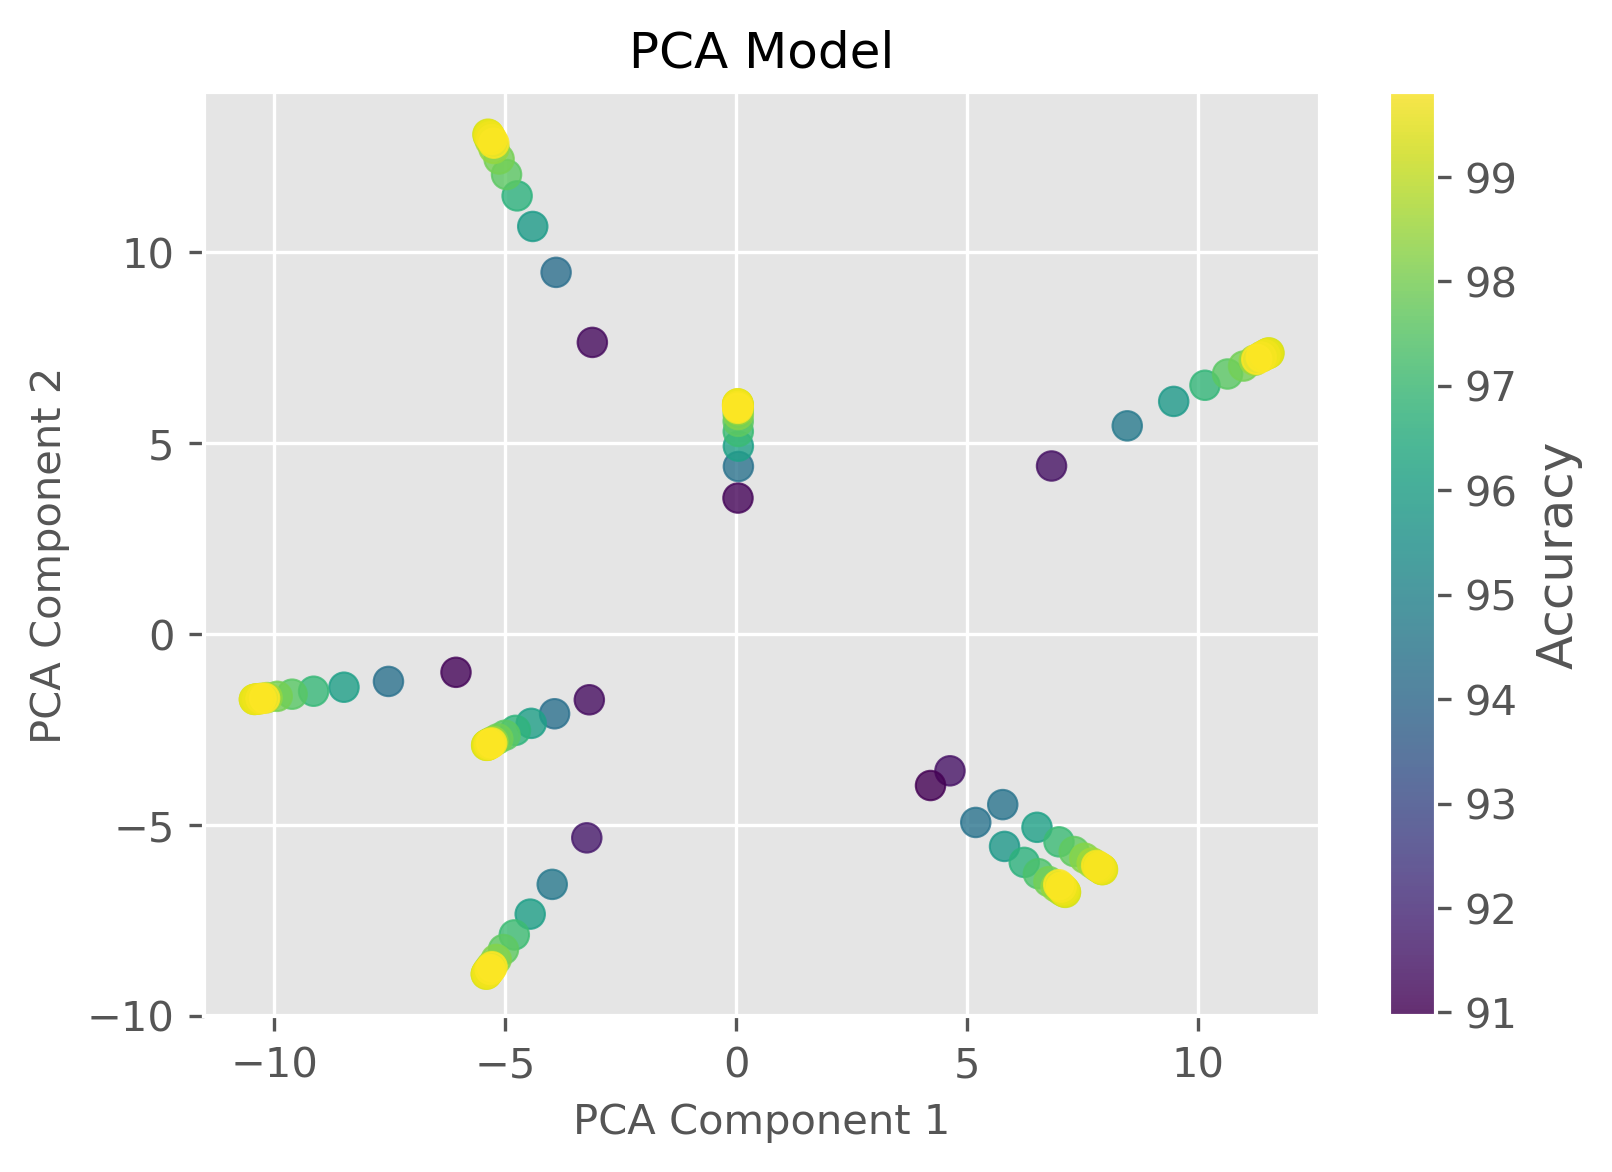

In [27]:
# test = np.array(epoch3Df.Acc)

# norm = plt.Normalize(test.min(), test.max())
# cmap = plt.get_cmap('viridis')  

# plt.figure(figsize=(5, 3), dpi=300)

# scatter = plt.scatter(
#     epoch3Df['x'], epoch3Df['y'],
#     c=test,        
#     s=(test * 0.5), 
#     cmap=cmap,     
#     alpha=0.8       
# )

# plt.colorbar(scatter, label='Accuracy')

# plt.title("PCA Model", fontsize=10, color="purple")
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')

# # sns.set(style="whitegrid")

# plt.show()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming epoch3Df is already defined with 'x', 'y', 'Acc'
test = np.array(epoch3Df['Acc'])

# Normalize accuracy values for color mapping
norm = plt.Normalize(test.min(), test.max())
cmap = plt.get_cmap('viridis')  # Using 'viridis' for a clean, professional color map

# Set up the figure with simplified aesthetics
plt.figure(figsize=(6, 4), dpi=300)

# Scatter plot with consistent marker size and normalized color
scatter = plt.scatter(
    epoch3Df['x'], epoch3Df['y'], 
    c=test,         # Color by accuracy
    s=50,           # Uniform marker size
    cmap=cmap,      # Apply color map
    alpha=0.8       # Maintain slight transparency for better readability
)

# Adding color bar for accuracy
plt.colorbar(scatter, label='Accuracy')

# Standardizing the title and labels for a simpler look
plt.title("PCA Model", fontsize=12, color="black")
plt.xlabel('PCA Component 1', fontsize=10)
plt.ylabel('PCA Component 2', fontsize=10)

# Display the plot
plt.show()



In [108]:
# Extract the first layer data from the full dataframe
layer1_data = results_df.iloc[:, 0:7840]
layer1_array = np.array(layer1_data)

# Perform PCA on the first layer data
pca_model_layer1 = PCA(n_components=2)
pca_layer1_data = pca_model_layer1.fit_transform(layer1_array)

# Create a DataFrame for the PCA-transformed layer 1 data
layer1_df = pd.DataFrame(pca_layer1_data, columns=['x', 'y'])

# Generate lists for epoch and iteration values
epochs_list = [epoch for epoch in range(max_epochs)] * 8
iterations_list = np.repeat([iteration for iteration in range(8)], max_epochs)

# Add Epoch, Iteration, Accuracy, and Loss columns to the layer 1 DataFrame
layer1_df['Epoch'] = epochs_list
layer1_df['Iteration'] = iterations_list
layer1_df['Accuracy'] = train_acc_flat
layer1_df['Loss'] = train_loss_flat

# Display the DataFrame
print(layer1_df)

# Plotting the PCA results for Layer 1
for index in range(len(modified_values)):
    marker_value = modified_values[index]
    iteration = layer1_df['Iteration'][index]
    
    # Scatter plot for PCA points with custom markers and color based on iteration
    plt.scatter(layer1_df['x'][index], 
                layer1_df['y'][index], 
                marker=f'${marker_value}$', 
                color=color_map[iteration])
    
    # Set the plot title
    plt.title("PCA for Layer 1", color="red")

# Save the plot as a PDF
# plt.savefig(path + '/PCA_Layer1.pdf', 
#             format='jpeg', 
#             dpi=700, 
#             bbox_inches='tight')

# Show the plot
plt.show()


NameError: name 'results_df' is not defined

OptimizationProcessVisualization

In [104]:
# Change the seed for reproducibility but different outputs
torch.manual_seed(42)

# Adjust the range and number of points in the x data
x = torch.unsqueeze(torch.linspace(-2, 2, 400), dim=1)  # x data (tensor), shape=(400, 1)

# Modify the non-linear function slightly for different output
y = (np.sin(3 * np.pi * x)) / (3 * np.pi * x) + 0.2 * np.cos(5 * np.pi * x)

# Print shapes for confirmation
print('Xshape:', x.shape, "\nYshape:", y.shape)

# Convert x and y to tensors with float32 type (remains unchanged)
x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
n_samples, n_features = x.shape

Xshape: torch.Size([400, 1]) 
Yshape: torch.Size([400, 1])


/local_scratch/slurm.712662/ipykernel_379349/1781617823.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [105]:


# Slightly modified model architecture
class model_1(nn.Module):
    def __init__(self):
        super(model_1, self).__init__()
        # Adding an extra layer to alter the model's behavior
        self.fc1 = nn.Linear(1, 300)      # Adjust the layer size
        self.fc2 = nn.Linear(300, 150)    # New hidden layer
        self.fc3 = nn.Linear(150, 1)      # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))          # New activation for the added layer
        x = self.fc3(x)
        return x

# Modified training function
def trainFunc(model, x, y):
    max_epoch = 2000  # Reduced max epochs to see faster behavior changes
    epoch_arr, loss_arr = [], []
    not_converged = True
    epoch = 0
    gradArr = []
    
    # Altering the optimizer and learning rate
    optimizer = optim.Adam(model.parameters(), lr=0.005)  # Switching to Adam optimizer

    while not_converged:
        epoch += 1
        prediction = model(x)  # input x and predict based on x
        loss = loss_func(prediction, y)  # must be (1. nn output, 2. target)
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients

        epoch_arr.append(epoch)
        loss_arr.append(loss.detach().numpy())

        # Generating Gradient Norm
        grad_all = 0.0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5

        optimizer.step()

        gradArr.append(grad_norm)

        # Print every 100 epochs
        if epoch % 100 == 0:
            print(f'epoch: {epoch}, loss = {loss.item():.4f}, grad_norm = {grad_norm}')
        
        # Adjust convergence criteria (make it stricter)
        if epoch == max_epoch:
            print("Max Epoch Reached")
            not_converged = False
        elif (epoch > 5) and (loss_arr[-1] < 0.001):
            if abs(loss_arr[-3] - loss_arr[-2]) < 1.0e-06 and abs(loss_arr[-2] - loss_arr[-1]) < 1.0e-06:
                print("Convergence reached for loss:", loss_arr[-1])
                not_converged = False

    return epoch_arr, loss_arr, prediction, grad_norm, gradArr


In [38]:

import torch.optim as optim
torch.manual_seed(42)  # Changed seed for different weight initialization

# Using the updated model architecture
m1 = model_1()  # define the network (assuming updated model_1 from previous responses)

# Change the optimizer parameters slightly for different behavior
optimizer = torch.optim.Adam(m1.parameters(), lr=5e-4, weight_decay=5e-5)  # Lower learning rate, smaller weight decay
loss_func = torch.nn.MSELoss()  # This remains the same (Mean Squared Error for regression)

# Print total number of parameters
a = []
for i in m1.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 1:', np.sum(a))

# Training the model with the modified parameters
model_1epoch_arr, model_1loss_arr, model_1prediction, model_1grad_norm, model_1gradArr = trainFunc(m1, x, y)


Total no of parameters in Model 1: 45901
epoch: 100, loss = 0.0381, grad_norm = 0.061822852617734174
epoch: 200, loss = 0.0251, grad_norm = 0.005776697701165803
epoch: 300, loss = 0.0246, grad_norm = 0.0037461583812975863
epoch: 400, loss = 0.0241, grad_norm = 0.005272795429330979
epoch: 500, loss = 0.0229, grad_norm = 0.0076429579896861765
epoch: 600, loss = 0.0201, grad_norm = 0.01181143502233989
epoch: 700, loss = 0.0151, grad_norm = 0.020223246304114824
epoch: 800, loss = 0.0142, grad_norm = 0.5521624806016241
epoch: 900, loss = 0.0102, grad_norm = 0.017094365916879968
epoch: 1000, loss = 0.0083, grad_norm = 0.008041311606486395
epoch: 1100, loss = 0.0069, grad_norm = 0.09364059794536403
epoch: 1200, loss = 0.0054, grad_norm = 0.005884963166125076
epoch: 1300, loss = 0.0044, grad_norm = 0.08760113804061634
epoch: 1400, loss = 0.0035, grad_norm = 0.015077378337788968
epoch: 1500, loss = 0.0032, grad_norm = 0.08551324138265926
epoch: 1600, loss = 0.0044, grad_norm = 0.349862017148896

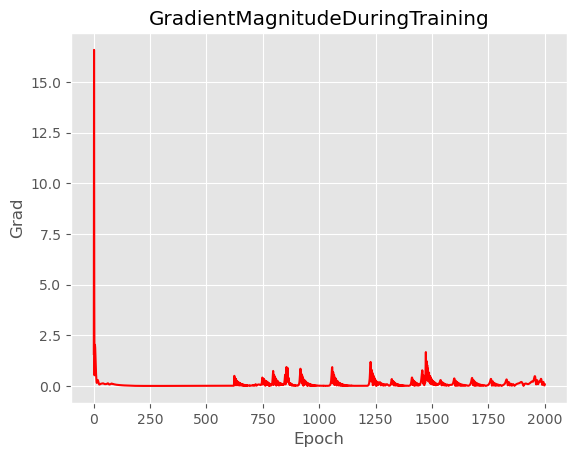

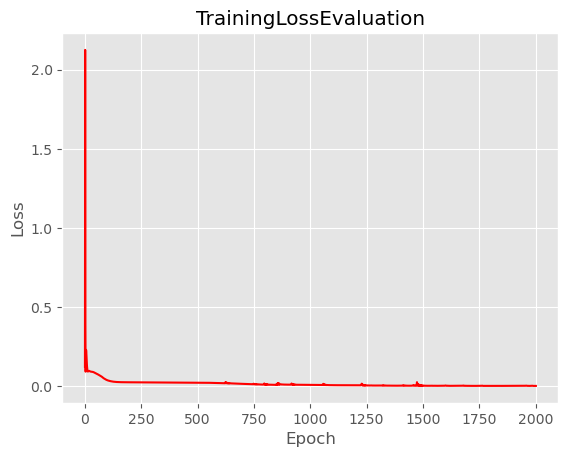

In [40]:
#plot 1
plt.plot(model_1epoch_arr,model_1gradArr,color="Red")
plt.title('GradientMagnitudeDuringTraining')
plt.xlabel("Epoch")
plt.ylabel("Grad")
plt.show()
#plot 2
plt.plot(model_1epoch_arr,model_1loss_arr,color="Red")
plt.title('TrainingLossEvaluation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [41]:
!pip install autograd_lib
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from autograd_lib import autograd_lib
from torch.utils.data import DataLoader, TensorDataset

Defaulting to user installation because normal site-packages is not writeable


In [61]:

Y_func = lambda x : (torch.sin(5*np.pi*x)) /(5*np.pi*x) 
num_of_rows = 300
X= torch.unsqueeze(torch.linspace(-1,1,num_of_rows),dim=1)
Y = Y_func(X)
dataset = TensorDataset(X,Y)
data_loader = DataLoader(dataset,1,shuffle=True)

In [62]:
class MathRegressor(nn.Module):
    def __init__(self, num_hidden=126):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x
    
    
    
    def training_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def train_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'train_loss': loss.detach()}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'train_loss': epoch_loss.item()}
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

In [74]:
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) 

    return grad_mean

def save_activations(layer, A, _):
    activations[layer] = A

def compute_hess(layer, _, B):
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) 
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA)
    
def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig, _ = torch.linalg.eigh(h)

        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) 

    return ratio_mean

In [75]:
def get_norm_minimal_ratio(model,criterion):

    gradient_norm = compute_gradient_norm(model, criterion, X, Y)
    minimum_ratio = compute_minimum_ratio(model, criterion, X, Y)

    print('gradient norm: {}, minimum ratio: {}'.format(gradient_norm, minimum_ratio))
    result = {}
    result["grad_norm"] = gradient_norm
    result["ratio"] = minimum_ratio
    
    return result


In [76]:

def evaluate(model,loss_fn, val_loader):
    outputs = [model.validation_step(batch,loss_fn) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate2(model,loss_fn, train_loader):
    outputs = [model.train_step(batch,loss_fn) for batch in train_loader]
    return model.train_epoch_end(outputs)

def get_grad_norm(model):
    grad_all=0.0
    grad =0
    
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
            
        grad_all+=grad
        
    grad_norm=grad_all ** 0.5
    return grad_norm


def fit(epochs, lr, model, data_loader, criterion,opt_func):
    history = []
    comparing_epoch_loss =1000.0
    grad_norm_per_epoch={}
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        prediction = model(X)
        loss = criterion(prediction, Y)
        loss.backward()
        grad_norm_per_epoch[epoch] = get_norm_minimal_ratio(model,criterion)
        optimizer.step() 
        optimizer.zero_grad()
        result = evaluate(model,criterion, data_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        if epoch == 900:
            comparing_epoch_loss= result["val_loss"]
    return history,grad_norm_per_epoch,model

In [89]:

num_of_rows = 300
lr = 0.0003
gamma_lr_scheduler = 0.1 
weight_decay = 1e-4
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2500
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
filename = criterion_name+ optimizer_name+".png"
grad_norm_name = "_grad_norm_name1_2.png"
result_folder_name = "result3/"
     

In [90]:

autograd_lib.register(model)
activations = defaultdict(int)
hess = defaultdict(float)

In [91]:
result_1 = evaluate(model,criterion,data_loader)

/home/snarale/.local/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [92]:
# filename = criterion_name+ optimizer_name+".png"

In [93]:

train,target = X,Y

In [94]:
class model_1(torch.nn.Module):
    def __init__(self,):
        super(model_1, self).__init__()
        self.hidden1 = torch.nn.Linear(1, 5)   # hidden layer
        self.hidden2 = torch.nn.Linear(5, 10)
        self.hidden3 = torch.nn.Linear (10, 10)
        self.hidden4 = torch.nn.Linear (10, 10)
        self.hidden5 = torch.nn.Linear (10, 10)
        self.hidden6 = torch.nn.Linear (10, 10)
        self.hidden7 = torch.nn.Linear (10,5)
        self.predict = torch.nn.Linear(5, 1)   # output layer
        #self.activation = nn.LeakyReLU()
        
    def forward(self, x):
        x = F.leaky_relu(self.hidden1(x))      # activation function for hidden layer
        x = F.leaky_relu(self.hidden2(x))
        x = F.leaky_relu(self.hidden3(x))
        x = F.leaky_relu(self.hidden4(x))
        x = F.leaky_relu(self.hidden5(x))
        x = F.leaky_relu(self.hidden6(x))
        x = F.leaky_relu(self.hidden7(x))
        x = self.predict(x)                    # linear output
        return x

model_0 = model_1()     # define the network

In [95]:
history_1,grad_norm_1,model  = fit(num_epochs, lr, model, data_loader, criterion,optimizer)

gradient norm: 4739.5162353515625, minimum ratio: 0.6015625
Epoch [0], val_loss: 56034.6797
gradient norm: 4742.0128173828125, minimum ratio: 0.60546875
Epoch [1], val_loss: 56079.2383
gradient norm: 4744.646392822266, minimum ratio: 0.62109375
Epoch [2], val_loss: 56123.8203
gradient norm: 4747.280029296875, minimum ratio: 0.59375
Epoch [3], val_loss: 56168.4219
gradient norm: 4749.913909912109, minimum ratio: 0.6015625
Epoch [4], val_loss: 56213.0352
gradient norm: 4752.423309326172, minimum ratio: 0.59765625
Epoch [5], val_loss: 56257.6992
gradient norm: 4755.059906005859, minimum ratio: 0.578125
Epoch [6], val_loss: 56302.3789
gradient norm: 4757.697204589844, minimum ratio: 0.58984375
Epoch [7], val_loss: 56347.0938
gradient norm: 4760.336151123047, minimum ratio: 0.59375
Epoch [8], val_loss: 56391.8477
gradient norm: 4762.977264404297, minimum ratio: 0.58203125
Epoch [9], val_loss: 56436.6055
gradient norm: 4765.618225097656, minimum ratio: 0.59765625
Epoch [10], val_loss: 56481.

In [96]:
val_losses_1 = [r['val_loss'] for r in history_1]

In [97]:
len(val_losses_1)
     

2500

In [98]:

minimal_ratio_eps = [i['ratio'] for i in grad_norm_1.values() ]

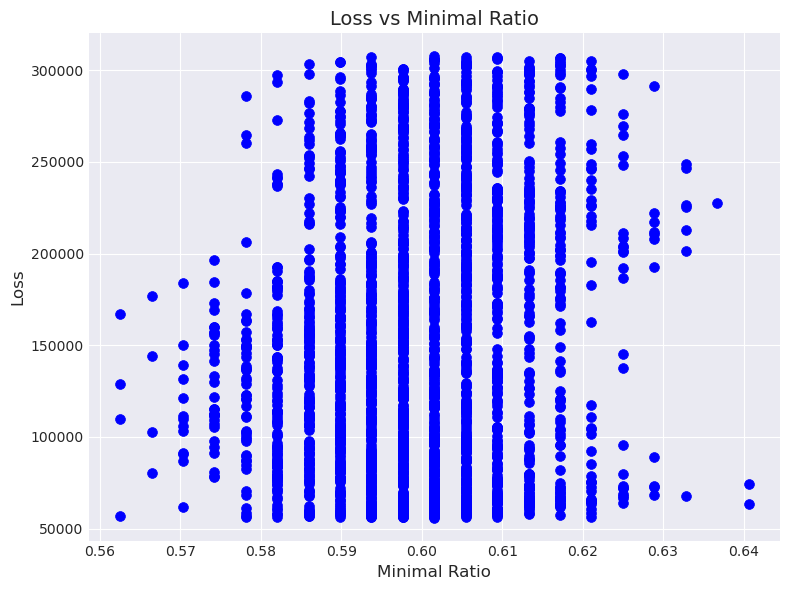

In [103]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(8, 6))

# Simple scatter plot with a uniform color and medium-sized markers
plt.scatter(minimal_ratio_eps, val_losses_1, color='blue', s=50)

# Add basic labels and title
plt.xlabel('Minimal Ratio', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs Minimal Ratio', fontsize=14)

# Add a grid for better readability
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()
